## Import training/test files in Pandas

In [1]:
import pandas as pd
import os 

print(os.getcwd())

/home/ubuntu/Desktop/multi-task-learning


In [2]:
train_data = pd.read_csv(os.path.join(os.getcwd() + '/data/training_csv'))
test_data = pd.read_csv(os.path.join(os.getcwd() + '/data/test_csv'))

In [3]:
# Note: we are enabling eager execution for debugging!

import numpy as np
import tensorflow as tf
tf.enable_eager_execution()

/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/anaconda3/envs/mondeique

In [4]:
# Example code for handling datasets
import matplotlib.pyplot as plt

# Load filenames and labels
filenames = tf.constant(train_data.iloc[:, 0].tolist())
labels = tf.constant(train_data.iloc[:, 1:].values)

# Add to a dataset object
dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

# We can debug using eager execution
for img, labels in dataset.batch(4).take(1):
    print(img)
    print(labels)

tf.Tensor(
[b'./data/cropped-bag-images-dev/5O2BQILGU6S_1.jpg'
 b'./data/cropped-bag-images-dev/X63VMOKHOQY_1.jpg'
 b'./data/cropped-bag-images-dev/TGEWLADRYBR_1.jpg'
 b'./data/cropped-bag-images-dev/SQJAPKTWWFJ_2.jpg'], shape=(4,), dtype=string)
tf.Tensor(
[[1]
 [4]
 [9]
 [1]], shape=(4, 1), dtype=int64)


In [5]:
# Reads an image from a file, decodes it into a dense tensor, and resizes it
# to a fixed shape.

def _parse_function(filename, label):
    print(filename)
    image_string = tf.read_file(filename) 
    print(image_string)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3) # Channels needed because some test images are b/w
    image_resized = tf.image.resize_images(image_decoded, [160, 160])
    image_shape = tf.cast(tf.shape(image_decoded), tf.float32)
#     label = tf.concat([label[:]], axis=0)
    return {"x": image_resized}, label

## Make Dataset

In [6]:
# This snippet is adapted from here: https://www.tensorflow.org/guide/datasets
def input_fn(dataframe, is_eval=False):

    # Load the list of files
    filenames = tf.constant(dataframe.iloc[:, 0].tolist())

    # Load the labels
    labels = tf.constant(dataframe.iloc[:, 1:].values)

    # Build the dataset with image processing on top of it
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(_parse_function)

    # Add shuffling and repeatition if training
    if is_eval:
        dataset = dataset.batch(64)
    else:
        dataset = dataset.repeat().shuffle(1000).batch(64)

    return dataset

Tensor("args_0:0", shape=(), dtype=string)
Tensor("ReadFile:0", shape=(), dtype=string)
tf.Tensor([1], shape=(1,), dtype=int64)
tf.Tensor([4], shape=(1,), dtype=int64)


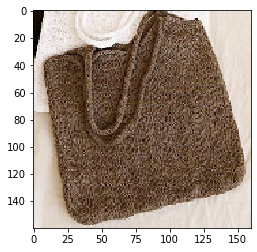

In [7]:
# Check the image & some labels
import matplotlib.pyplot as plt
for (imgs, labels) in input_fn(train_data, is_eval=True).take(1):
    plt.imshow(imgs['x'][0] / 255)
    print(labels[0])
    print(labels[1])

## Standard classical estimator (single-task only!)

### Reimplement the feature extraction from the original paper

In [8]:
def extract_features(features):
    # Input layer
    input_layer = tf.reshape(features["x"], [-1, 160, 160, 3])

    # First convolutive layer
    conv1 = tf.layers.conv2d(inputs=input_layer, filters=16, kernel_size=[5, 5], padding="same", activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Second convolutive layer
    conv2 = tf.layers.conv2d(inputs=pool1, filters=48, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Third convolutive layer
    conv3 = tf.layers.conv2d(inputs=pool2, filters=64, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)
    
    # Fourth convolutive layer
    conv4 = tf.layers.conv2d(inputs=pool3, filters=64, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    pool4 = tf.layers.max_pooling2d(inputs=conv4, pool_size=[2, 2], strides=2)
    
    # Fifth convolutive layer
    conv5 = tf.layers.conv2d(inputs=pool4, filters=128, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    pool5 = tf.layers.max_pooling2d(inputs=conv5, pool_size=[2, 2], strides=2)

    # Fourth convolutive layer
    conv4 = tf.layers.conv2d(inputs=pool3, filters=128, kernel_size=[2, 2], padding="same", activation=tf.nn.relu)

    # Dense Layer
    flat = tf.reshape(conv4, [-1, 20 * 20 * 128])
    dense = tf.layers.dense(inputs=flat, units=100, activation=tf.nn.relu)
  
    return dense

### single task cnn model

In [9]:
# Adapted from here: https://www.tensorflow.org/tutorials/layers
def single_task_cnn_model_fn(features, labels, mode):
  
    # Get features
    dense = extract_features(features)
  
    # Make predictions
    logits = tf.layers.dense(inputs=dense, units=11)

    predicted_class = tf.argmax(logits, 1)
    
    outputs = {
        "predicted_class": predicted_class,
        "probabilities": tf.nn.softmax(logits),
        "logits": logits
    }

    # We just want the predictions
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=outputs)

    # If not in mode.PREDICT, compute the loss 
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels[:], logits=logits)

    # Single optimization step
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer()
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # If not PREDICT or TRAIN, then we are evaluating the model
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels[:, 0], predictions=outputs["predicted_class"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

### Build the Estimator

In [10]:
single_task_classifier = tf.estimator.Estimator(
    model_fn=single_task_cnn_model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp6r7jqeva', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7ca0412690>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Train & evaluate & test model

In [12]:
# Train the model
single_task_classifier.train(input_fn=lambda: input_fn(train_data), steps=1000)

Tensor("args_0:0", shape=(), dtype=string)
Tensor("ReadFile:0", shape=(), dtype=string)
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /tmp/tmp6r7jqeva/model.ckpt-5000
Instructions for updating:
Use standard file utilities to get mtimes.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 5000 into /tmp/tmp6r7jqeva/model.ckpt.
INFO:tensorflow:loss = 7.282912e-07, step = 5001
INFO:tensorflow:global_step/sec: 1.15634
INFO:tensorflow:loss = 3.669409e-07, step = 5101 (86.481 sec)
INFO:tensorflow:global_step/sec: 1.15897
INFO:tensorflow:loss = 2.4400634e-07, step = 5201 (86.283 sec)
INFO:tensorflow:global_step/sec: 1.16739
INFO:tensorflow:loss = 3.7252872e-07, step = 5301 (85.661 sec)
INFO:tensorflow:global_step/sec: 1.1668
INFO:tensorflow:loss = 2.756713e-07, step = 5401 (85.705 sec)
INFO:tensorflow:global_st

In [13]:
single_task_classifier.evaluate(input_fn=lambda: input_fn(test_data, is_eval=True))

Tensor("args_0:0", shape=(), dtype=string)
Tensor("ReadFile:0", shape=(), dtype=string)
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-01-06T12:57:34Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp6r7jqeva/model.ckpt-6000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2020-01-06-12:57:36
INFO:tensorflow:Saving dict for global step 6000: accuracy = 0.61959, global_step = 6000, loss = 6.6786914
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6000: /tmp/tmp6r7jqeva/model.ckpt-6000


{'accuracy': 0.61959, 'loss': 6.6786914, 'global_step': 6000}

In [14]:
p = list(single_task_classifier.predict(lambda: input_fn(test_data, is_eval=True)))

Tensor("args_0:0", shape=(), dtype=string)
Tensor("ReadFile:0", shape=(), dtype=string)
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp6r7jqeva/model.ckpt-6000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [15]:
p

[{'predicted_class': 6,
  'probabilities': array([0.0000000e+00, 7.3320552e-04, 2.6560232e-10, 6.0941074e-13,
         1.8467854e-01, 1.6164751e-10, 8.1458819e-01, 7.9739524e-13,
         4.2679259e-11, 8.2677728e-12, 1.8006467e-34], dtype=float32),
  'logits': array([-39.57619 ,  48.566887,  33.73595 ,  27.658688,  54.095833,
          33.23937 ,  55.5799  ,  27.927546,  31.907663,  30.266315,
         -21.914774], dtype=float32)},
 {'predicted_class': 5,
  'probabilities': array([0.0000000e+00, 3.7133903e-33, 2.5991175e-18, 5.8750543e-12,
         4.3402521e-25, 1.0000000e+00, 6.3486676e-35, 1.9834340e-30,
         2.8420740e-20, 0.0000000e+00, 0.0000000e+00], dtype=float32),
  'logits': array([-121.38308  ,   14.104235 ,   48.286236 ,   62.91729  ,
           32.6809   ,   88.777596 ,   10.035364 ,   20.38487  ,
           43.770428 ,  -11.079176 ,   -3.3749251], dtype=float32)},
 {'predicted_class': 1,
  'probabilities': array([1.7428910e-22, 5.5740356e-01, 4.9481365e-05, 1.3921314

Tensor("args_0:0", shape=(), dtype=string)
Tensor("ReadFile:0", shape=(), dtype=string)
5


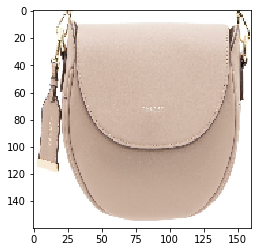

In [21]:
# Evaluate a single prediction
for imgs, _ in input_fn(test_data, is_eval=True).take(1):
    img_idx = 33
    plt.imshow(imgs["x"][img_idx] / 255)
    print(p[img_idx]['predicted_class'])

## model.ckpt restore and save

In [44]:

with tf.Session() as sess :

    # Saver instance 를 생성한다.
    # Saver.restore(sess, ckpt_path)
    saver = tf.train.import_meta_graph('/tmp/tmph9ruxrc_/model.ckpt-5000.meta')
    saver.restore(sess, '/tmp/tmph9ruxrc_/model.ckpt-5000')
    graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from /tmp/tmph9ruxrc_/model.ckpt-5000


In [50]:
tf.estimator.Estimator.predict(model_checkpoint_path = '/tmp/tmph9ruxrc_/model.ckpt-5000')

TypeError: predict() got an unexpected keyword argument 'model_checkpoint_path'